In [1]:
# STEP 1: Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [2]:
# Set options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [3]:
# STEP 2: Load Data
base_path = "/kaggle/input/treadmill-raw-data/treadmill-maximal-exercise-tests-from-the-exercise-physiology-and-human-performance-lab-of-the-university-of-malaga-1.0.1"
subject_info = pd.read_csv(f"{base_path}/subject-info.csv")
test_measure = pd.read_csv(f"{base_path}/test_measure.csv")

In [4]:
# STEP 3: Basic Exploration
print("Subject Info:")
print(subject_info.head())
print("Test Measure Info:")
print(test_measure.head())
print("Test Measure Columns:", test_measure.columns.tolist())

Subject Info:
    Age  Weight  Height  Humidity  Temperature  Sex   ID ID_test
0  10.8    48.8   163.0      39.0         20.7    1  543   543_1
1  11.8    41.0   150.0      41.0         22.3    1   11    11_1
2  12.2    46.0   160.0      37.0         21.5    0  829   829_1
3  13.2    71.0   190.0      49.0         23.8    1  284   284_1
4  13.7    53.8   169.7      40.0         25.3    0  341   341_1
Test Measure Info:
   time  Speed    HR    VO2   VCO2  RR    VE ID_test  ID
0     0    5.0  63.0  478.0  360.0  27  13.3     2_1   2
1     2    5.0  75.0  401.0  295.0  23  10.3     2_1   2
2     4    5.0  82.0  449.0  319.0  29  12.2     2_1   2
3     7    5.0  87.0  461.0  340.0  28  12.8     2_1   2
4     9    5.0  92.0  574.0  417.0  28  14.6     2_1   2
Test Measure Columns: ['time', 'Speed', 'HR', 'VO2', 'VCO2', 'RR', 'VE', 'ID_test', 'ID']


In [5]:
# STEP 4: Clean & Filter Relevant Signals
df = test_measure.copy()
df = df[['ID_test', 'time', 'HR', 'RR', 'VO2', 'Speed']]
df = df.dropna(subset=['HR', 'RR', 'VO2', 'Speed'])

In [6]:
# STEP 5: Feature Engineering - Sliding Window
window_size = 120  # seconds
step_size = 10
features = []

for test_id, group in df.groupby('ID_test'):
    group = group.sort_values('time')
    max_time = group['time'].max()

    for start in range(0, int(max_time) - window_size + 1, step_size):
        end = start + window_size
        window = group[(group['time'] >= start) & (group['time'] < end)]

        if len(window) < 5:
            continue

        try:
            features.append({
                "ID_test": test_id,
                "start": start,
                "end": end,
                "HR_mean": window['HR'].mean(),
                "HR_std": window['HR'].std(),
                "HR_slope": np.polyfit(window['time'], window['HR'], 1)[0],
                "RR_mean": window['RR'].mean(),
                "RR_std": window['RR'].std(),
                "RR_slope": np.polyfit(window['time'], window['RR'], 1)[0],
                "VO2_mean": window['VO2'].mean(),
                "VO2_slope": np.polyfit(window['time'], window['VO2'], 1)[0],
            })
        except:
            continue

features_df = pd.DataFrame(features)

In [7]:
# Labeling logic based on distribution
# STEP 6: Threshold-Based Labeling (using percentiles)
thresh = features_df.describe(percentiles=[0.25, 0.5, 0.75])

conditions = [
    (features_df['HR_std'] >= thresh.loc['75%', 'HR_std']) &
    (features_df['RR_std'] >= thresh.loc['75%', 'RR_std']),

    (features_df['HR_mean'] >= thresh.loc['75%', 'HR_mean']) &
    (features_df['RR_mean'] >= thresh.loc['75%', 'RR_mean']),

    (features_df['HR_slope'] >= thresh.loc['75%', 'HR_slope']) &
    (features_df['RR_slope'] >= thresh.loc['75%', 'RR_slope']),
]

labels = ['acute', 'chronic', 'episodic_acute']
features_df['label'] = np.select(conditions, labels, default='no_stress')

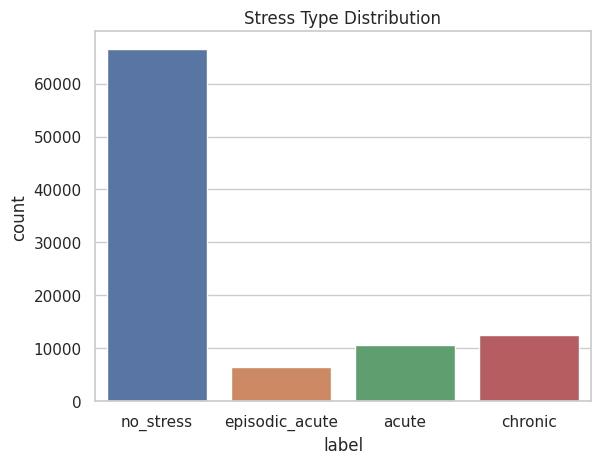

In [8]:
# STEP 7: Visualize Class Distribution
sns.countplot(data=features_df, x='label')
plt.title("Stress Type Distribution")
plt.show()

# STEP 8: Balance Classes
max_count = features_df['label'].value_counts().min()
balanced_df = pd.concat([
    resample(g, replace=False, n_samples=max_count, random_state=42)
    for _, g in features_df.groupby('label')
])

In [9]:
# STEP 9: Train/Test Split
X = balanced_df[['HR_mean', 'HR_std', 'HR_slope', 'RR_mean', 'RR_std', 'RR_slope', 'VO2_mean', 'VO2_slope']]
y = balanced_df['label']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [10]:
# STEP 10: Train Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

                precision    recall  f1-score   support

         acute       1.00      1.00      1.00      1292
       chronic       1.00      1.00      1.00      1281
episodic_acute       1.00      1.00      1.00      1241
     no_stress       1.00      1.00      1.00      1301

      accuracy                           1.00      5115
     macro avg       1.00      1.00      1.00      5115
  weighted avg       1.00      1.00      1.00      5115



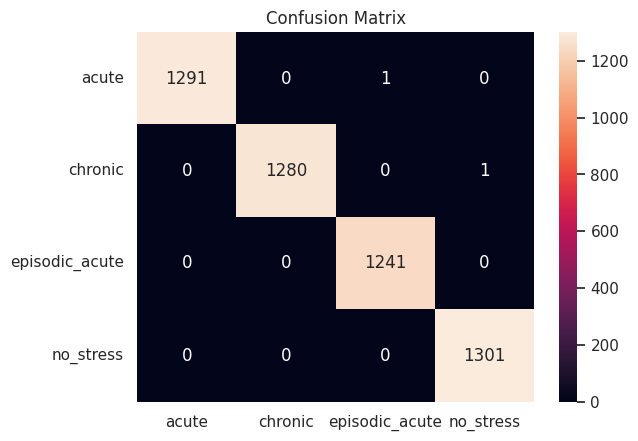

In [11]:
# STEP 11: Evaluate
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()

In [12]:
# STEP 12: Inference Example
sample = X_test.iloc[:5]
preds = le.inverse_transform(clf.predict(sample))
print("Sample Predictions:", preds)

Sample Predictions: ['no_stress' 'chronic' 'acute' 'acute' 'no_stress']


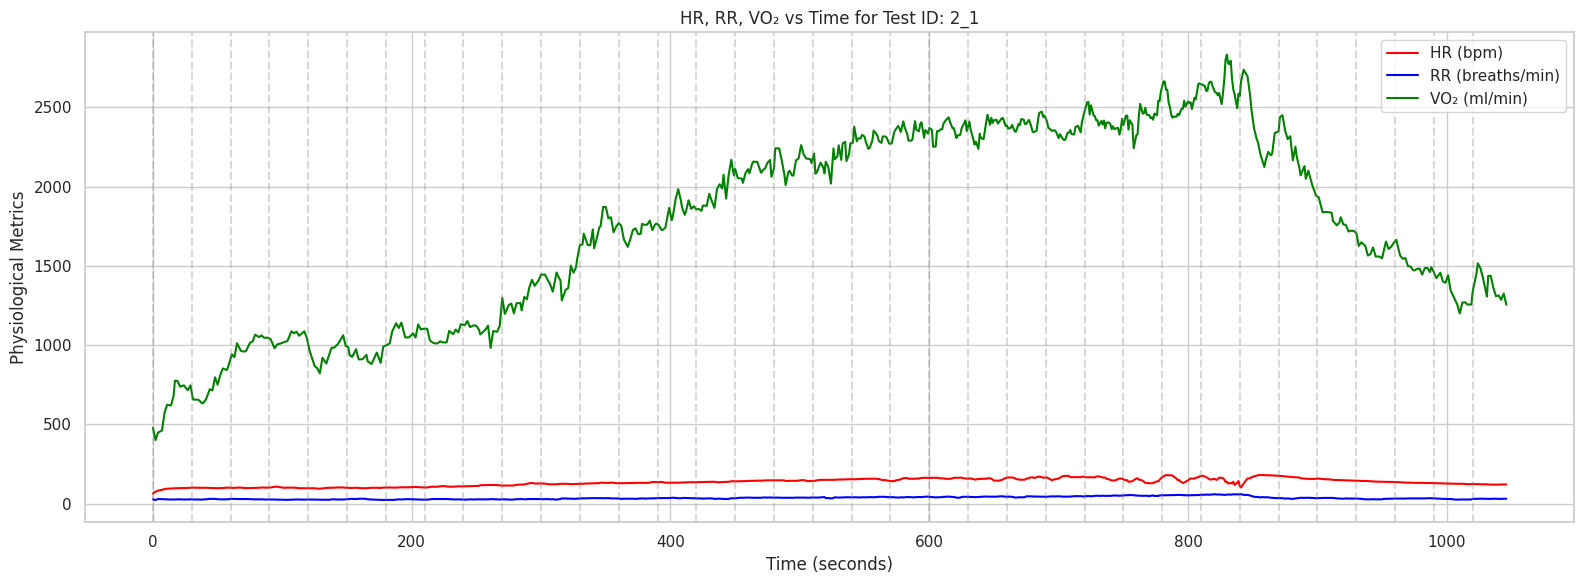

In [13]:
# Choose a test ID to visualize
test_id = df['ID_test'].iloc[0]  # or pick a specific ID manually
plot_data = df[df['ID_test'] == test_id]

# Plot HR, RR, and VO2 over time
plt.figure(figsize=(16, 6))
plt.plot(plot_data['time'], plot_data['HR'], label='HR (bpm)', color='red')
plt.plot(plot_data['time'], plot_data['RR'], label='RR (breaths/min)', color='blue')
plt.plot(plot_data['time'], plot_data['VO2'], label='VO₂ (ml/min)', color='green')

# Add vertical lines to show sliding window segments
for t in range(0, int(plot_data['time'].max()), 30):
    plt.axvline(x=t, color='gray', linestyle='--', alpha=0.3)

plt.title(f"HR, RR, VO₂ vs Time for Test ID: {test_id}")
plt.xlabel("Time (seconds)")
plt.ylabel("Physiological Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


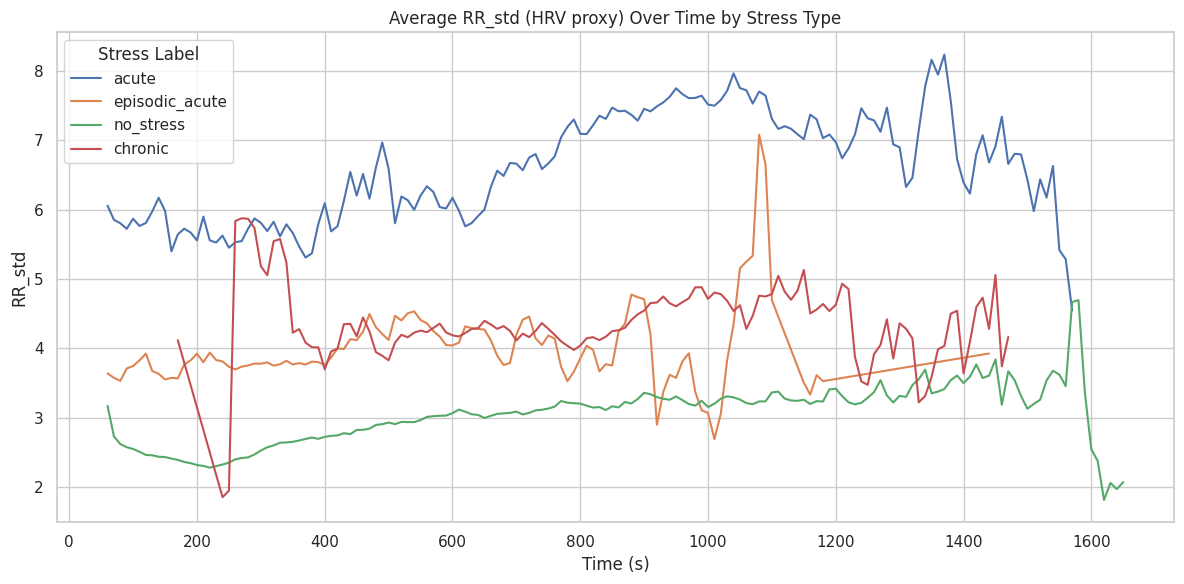

In [14]:
# Create midpoint of the sliding window to represent "time"
features_df['mid_time'] = (features_df['start'] + features_df['end']) / 2

# Group by time and label, then compute mean RR_std
agg_df = features_df.groupby(['mid_time', 'label'])['RR_std'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
for label in agg_df['label'].unique():
    label_data = agg_df[agg_df['label'] == label]
    plt.plot(label_data['mid_time'], label_data['RR_std'], label=label)

plt.title("Average RR_std (HRV proxy) Over Time by Stress Type")
plt.xlabel("Time (s)")
plt.ylabel("RR_std")
plt.legend(title="Stress Label")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# STEP 1: Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [16]:
# Set options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# STEP 2: Load Data
base_path = "/kaggle/input/treadmill-raw-data/treadmill-maximal-exercise-tests-from-the-exercise-physiology-and-human-performance-lab-of-the-university-of-malaga-1.0.1"
subject_info = pd.read_csv(f"{base_path}/subject-info.csv")
test_measure = pd.read_csv(f"{base_path}/test_measure.csv")

In [17]:
# STEP 3: Basic Exploration
print("Subject Info:")
print(subject_info.head())
print("Test Measure Info:")
print(test_measure.head())
print("Test Measure Columns:", test_measure.columns.tolist())

Subject Info:
    Age  Weight  Height  Humidity  Temperature  Sex   ID ID_test
0  10.8    48.8   163.0      39.0         20.7    1  543   543_1
1  11.8    41.0   150.0      41.0         22.3    1   11    11_1
2  12.2    46.0   160.0      37.0         21.5    0  829   829_1
3  13.2    71.0   190.0      49.0         23.8    1  284   284_1
4  13.7    53.8   169.7      40.0         25.3    0  341   341_1
Test Measure Info:
   time  Speed    HR    VO2   VCO2  RR    VE ID_test  ID
0     0    5.0  63.0  478.0  360.0  27  13.3     2_1   2
1     2    5.0  75.0  401.0  295.0  23  10.3     2_1   2
2     4    5.0  82.0  449.0  319.0  29  12.2     2_1   2
3     7    5.0  87.0  461.0  340.0  28  12.8     2_1   2
4     9    5.0  92.0  574.0  417.0  28  14.6     2_1   2
Test Measure Columns: ['time', 'Speed', 'HR', 'VO2', 'VCO2', 'RR', 'VE', 'ID_test', 'ID']


In [18]:
# STEP 4: Clean & Filter Relevant Signals
df = test_measure.copy()
df = df[['ID_test', 'time', 'HR', 'RR', 'VO2', 'Speed']]
df = df.dropna(subset=['HR', 'RR', 'VO2', 'Speed'])

In [19]:
# STEP 5: Feature Engineering - Sliding Window
window_size = 30  # seconds
step_size = 10
features = []

for test_id, group in df.groupby('ID_test'):
    group = group.sort_values('time')
    max_time = group['time'].max()

    for start in range(0, int(max_time) - window_size + 1, step_size):
        end = start + window_size
        window = group[(group['time'] >= start) & (group['time'] < end)]

        if len(window) < 5:
            continue

        try:
            features.append({
                "ID_test": test_id,
                "start": start,
                "end": end,
                "HR_mean": window['HR'].mean(),
                "HR_std": window['HR'].std(),
                "HR_slope": np.polyfit(window['time'], window['HR'], 1)[0],
                "RR_mean": window['RR'].mean(),
                "RR_std": window['RR'].std(),
                "RR_slope": np.polyfit(window['time'], window['RR'], 1)[0],
                "VO2_mean": window['VO2'].mean(),
                "VO2_slope": np.polyfit(window['time'], window['VO2'], 1)[0],
            })
        except:
            continue

features_df = pd.DataFrame(features)

In [20]:
# STEP 6: Improved Threshold-Based Labeling
numeric_cols = features_df.select_dtypes(include='number').columns
quantiles = features_df[numeric_cols].quantile(q=[0.25, 0.5, 0.75])

# quantiles = features_df.quantile(q=[0.25, 0.5, 0.75]).reset_index()
# quantiles.set_index('index', inplace=True)
features_df['label'] = 'no_stress'  # default

features_df.loc[
    (features_df['HR_std'] > quantiles.loc[0.75, 'HR_std']) &
    (features_df['RR_std'] > quantiles.loc[0.75, 'RR_std']),
    'label'
] = 'acute'

features_df.loc[
    (features_df['HR_mean'] > quantiles.loc[0.75, 'HR_mean']) &
    (features_df['RR_mean'] > quantiles.loc[0.75, 'RR_mean']),
    'label'
] = 'chronic'

features_df.loc[
    (features_df['HR_slope'] > quantiles.loc[0.75, 'HR_slope']) &
    (features_df['RR_slope'] > quantiles.loc[0.75, 'RR_slope']),
    'label'
] = 'episodic_acute'


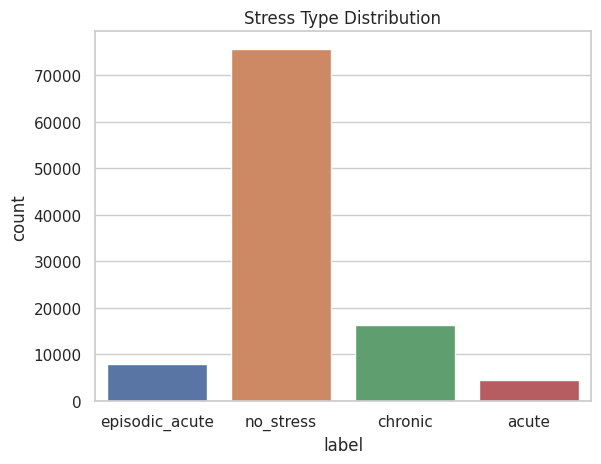

In [21]:
# STEP 7: Visualize Class Distribution
sns.countplot(data=features_df, x='label')
plt.title("Stress Type Distribution")
plt.show()

In [22]:
# STEP 8: Balance Classes
min_count = features_df['label'].value_counts().min()
balanced_df = pd.concat([
    resample(group, replace=False, n_samples=min_count, random_state=42)
    for _, group in features_df.groupby('label')
])

In [23]:
# STEP 9: Train/Test Split
X = balanced_df[['HR_mean', 'HR_std', 'HR_slope', 'RR_mean', 'RR_std', 'RR_slope', 'VO2_mean', 'VO2_slope']]
y = balanced_df['label']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [24]:
# STEP 10: Train Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

                precision    recall  f1-score   support

         acute       1.00      1.00      1.00       887
       chronic       1.00      1.00      1.00       890
episodic_acute       1.00      1.00      1.00       919
     no_stress       1.00      1.00      1.00       860

      accuracy                           1.00      3556
     macro avg       1.00      1.00      1.00      3556
  weighted avg       1.00      1.00      1.00      3556



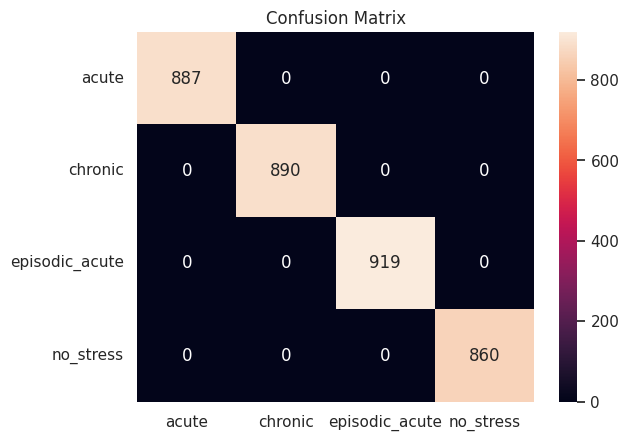

Sample Predictions: ['chronic' 'acute' 'episodic_acute' 'episodic_acute' 'chronic']


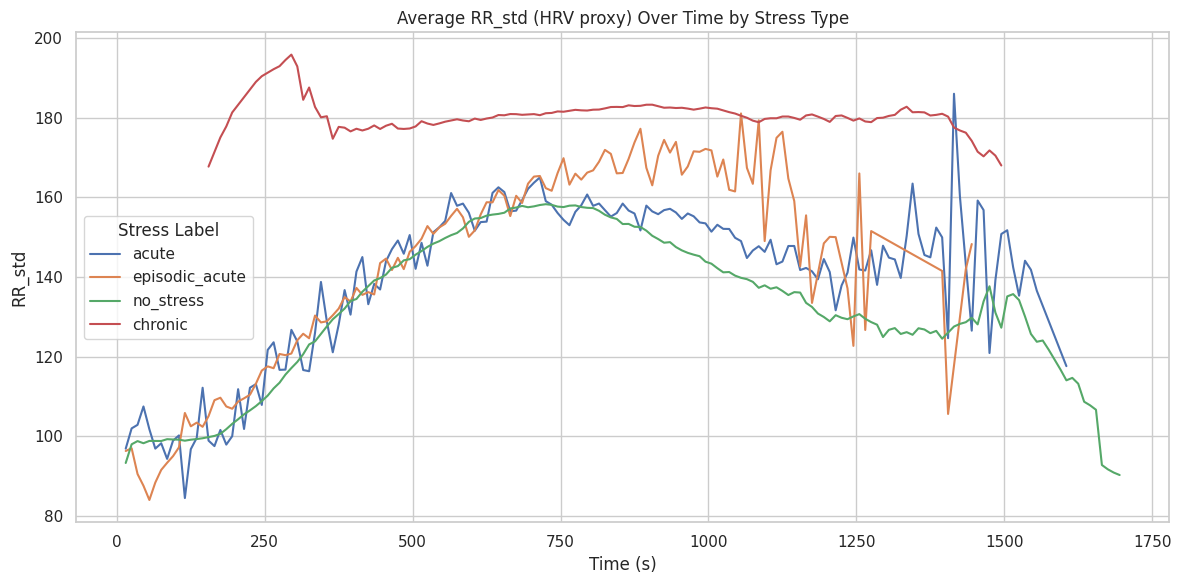

In [25]:
# STEP 11: Evaluate
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()

# STEP 12: Inference Example
sample = X_test.iloc[:5]
preds = le.inverse_transform(clf.predict(sample))
print("Sample Predictions:", preds)

# STEP 13: Visualization - RR_std over time per stress label
features_df['stress_score'] = (
    0.6 * features_df['HR_mean'].rank(pct=True) +
    0.4 * features_df['RR_std'].rank(pct=True)
)
features_df['mid_time'] = (features_df['start'] + features_df['end']) / 2
agg_df = features_df.groupby(['mid_time', 'label'])['HR_mean'].mean().reset_index()

plt.figure(figsize=(12, 6))
for label in agg_df['label'].unique():
    label_data = agg_df[agg_df['label'] == label]
    plt.plot(label_data['mid_time'], label_data['HR_mean'], label=label)

plt.title("Average RR_std (HRV proxy) Over Time by Stress Type")
plt.xlabel("Time (s)")
plt.ylabel("RR_std")
plt.legend(title="Stress Label")
plt.grid(True)
plt.tight_layout()
plt.show()

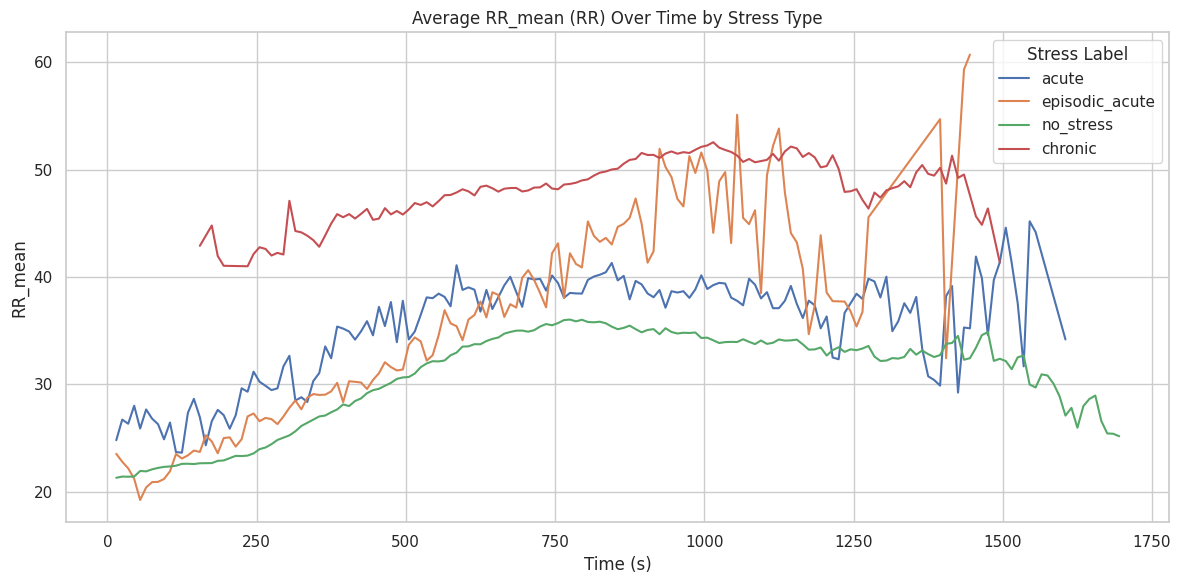

In [26]:
features_df['mid_time'] = (features_df['start'] + features_df['end']) / 2
agg_df = features_df.groupby(['mid_time', 'label'])['RR_mean'].mean().reset_index()

plt.figure(figsize=(12, 6))
for label in agg_df['label'].unique():
    label_data = agg_df[agg_df['label'] == label]
    plt.plot(label_data['mid_time'], label_data['RR_mean'], label=label)

plt.title("Average RR_mean (RR) Over Time by Stress Type")
plt.xlabel("Time (s)")
plt.ylabel("RR_mean")
plt.legend(title="Stress Label")
plt.grid(True)
plt.tight_layout()
plt.show()

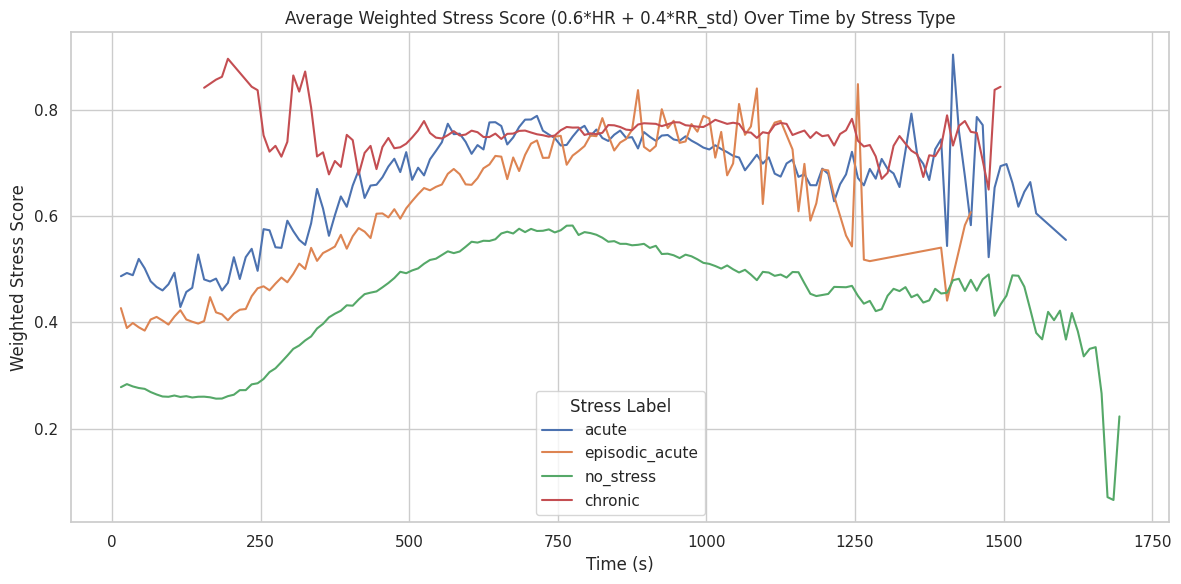

In [27]:
# Fixed weights: 55% HR_mean, 45% RR_std
features_df['stress_score'] = (
    0.55 * features_df['HR_mean'].rank(pct=True) +
    0.45 * features_df['RR_std'].rank(pct=True)
)
features_df['mid_time'] = (features_df['start'] + features_df['end']) / 2
# Aggregate average stress score over time per label
agg_df = features_df.groupby(['mid_time', 'label'])['stress_score'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
for label in agg_df['label'].unique():
    label_data = agg_df[agg_df['label'] == label]
    plt.plot(label_data['mid_time'], label_data['stress_score'], label=label)

plt.title("Average Weighted Stress Score (0.6*HR + 0.4*RR_std) Over Time by Stress Type")
plt.xlabel("Time (s)")
plt.ylabel("Weighted Stress Score")
plt.legend(title="Stress Label")
plt.grid(True)
plt.tight_layout()
plt.show()


Dynamic Weights:
  HR_mean: 0.26
  RR_std: 0.11
  VO2_mean: 0.19
  RR_mean: 0.44


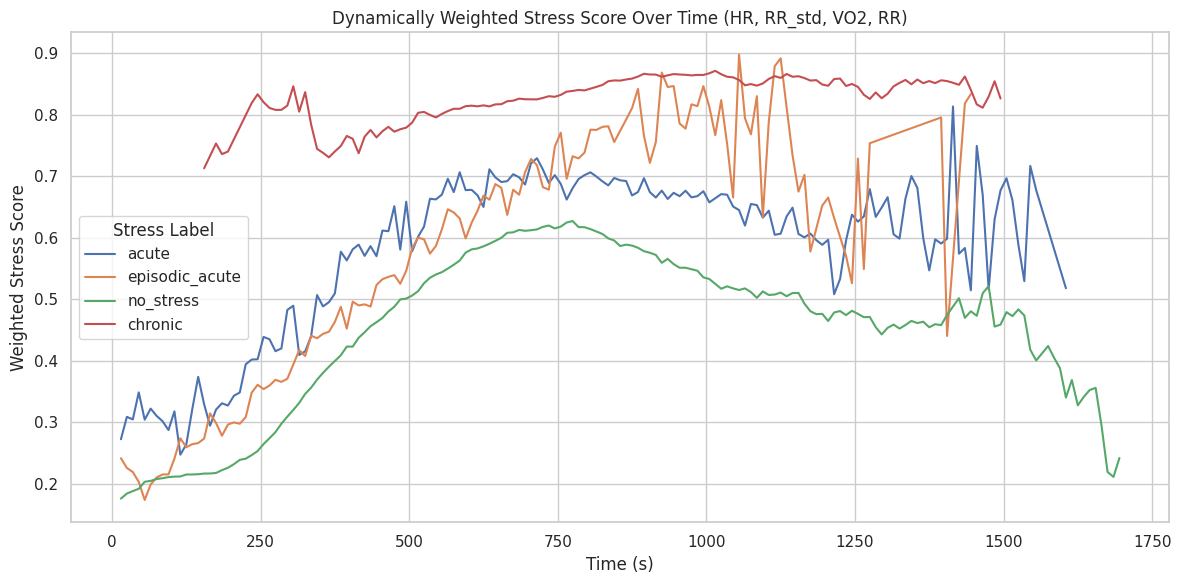

In [28]:
from sklearn.feature_selection import f_classif

# Select features and target
feature_cols = ['HR_mean', 'RR_std', 'VO2_mean', 'RR_mean']
X = features_df[feature_cols]
y = features_df['label']

# Compute ANOVA F-scores for each feature
f_scores, _ = f_classif(X, y)

# Normalize F-scores to derive weights
weights = f_scores / f_scores.sum()
weight_dict = dict(zip(feature_cols, weights))
print("Dynamic Weights:")
for feat, w in weight_dict.items():
    print(f"  {feat}: {w:.2f}")

# Compute stress score using weighted sum of percentile ranks
features_df['stress_score'] = sum(
    weight_dict[feat] * features_df[feat].rank(pct=True) for feat in feature_cols
)
features_df['mid_time'] = (features_df['start'] + features_df['end']) / 2
# Aggregate and plot
agg_df = features_df.groupby(['mid_time', 'label'])['stress_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
for label in agg_df['label'].unique():
    label_data = agg_df[agg_df['label'] == label]
    plt.plot(label_data['mid_time'], label_data['stress_score'], label=label)

plt.title("Dynamically Weighted Stress Score Over Time (HR, RR_std, VO2, RR)")
plt.xlabel("Time (s)")
plt.ylabel("Weighted Stress Score")
plt.legend(title="Stress Label")
plt.grid(True)
plt.tight_layout()
plt.show()


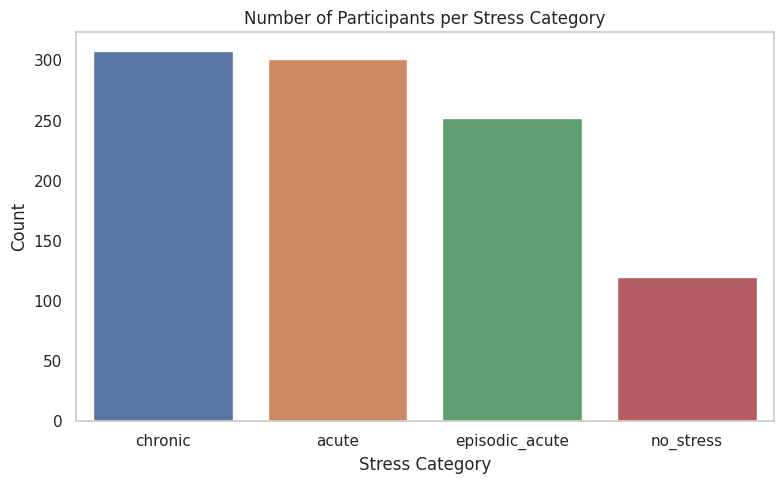

In [41]:
# Plot bar chart
plt.figure(figsize=(8, 5))
sns.countplot(data=subject_features, x='stress_category', order=subject_features['stress_category'].value_counts().index)
plt.title("Number of Participants per Stress Category")
plt.xlabel("Stress Category")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
